# LangGraph Basics 

In [8]:
from typing import Annotated

from ollama import embeddings
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama, OllamaEmbeddings
from rich import print as pp
llm = ChatOllama(model="llama3.2", temperature=0.3)

embeddings = OllamaEmbeddings(model='snowflake-arctic-embed:33m')

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)



def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)


graph_builder.add_edge(START, "chatbot")

graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()



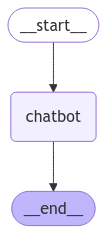

In [3]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [4]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [10]:
from langchain_openai import ChatOpenAI
# load env
import os
from dotenv import load_dotenv

llm = ChatOpenAI()
pp(llm.invoke("Hello, world!").content)

Hello! How can I assist you today?

In [12]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import ShellTool
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]

llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

ValidationError: 1 validation error for TavilySearchAPIWrapper
  Value error, Did not find tavily_api_key, please add an environment variable `TAVILY_API_KEY` which contains it, or pass `tavily_api_key` as a named parameter. [type=value_error, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/value_error

In [13]:
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import Graph
import operator
from langchain_core.runnables import RunnablePassthrough

# Define our state
class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], operator.add]
    next_step: str

# Define the nodes (functions) that will process our state
def human_input(state: AgentState) -> AgentState:
    """Process human input and decide next step."""
    last_message = state["messages"][-1]
    # Simple logic: if message contains "bye", end conversation
    if "bye" in last_message.content.lower():
        return {"messages": state["messages"], "next_step": "end"}
    return {"messages": state["messages"], "next_step": "ai_response"}

def ai_response(state: AgentState) -> AgentState:
    """Generate AI response."""
    # In a real application, you would use an LLM here
    response = f"AI: I acknowledge your message: {state['messages'][-1].content}"
    return {
        "messages": state["messages"] + [AIMessage(content=response)],
        "next_step": "human_input"
    }

# Create the graph
workflow = Graph()

# Add nodes to the graph
workflow.add_node("human_input", human_input)
workflow.add_node("ai_response", ai_response)

# Define the edges (connections between nodes)
workflow.add_edge("human_input", "ai_response")
workflow.add_edge("ai_response", "human_input")

# Set the entry point
workflow.set_entry_point("human_input")

# Compile the graph
app = workflow.compile()

# Example usage
messages = [HumanMessage(content="Hello, how are you?")]
initial_state = {"messages": messages, "next_step": "human_input"}

# Run the workflow
for state in app.stream(initial_state):
    # print(state["messages"][-1].content)
    
    # Break if we reach the end
    if state["next_step"] == "end":
        break
    
    # In a real application, you would get actual user input here
    user_input = "bye"  # Simulated user input
    state["messages"].append(HumanMessage(content=user_input))


{'human_input': {'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={})], 'next_step': 'ai_response'}}


KeyError: 'next_step'

ImportError: cannot import name 'LangGraph' from 'langgraph' (unknown location)

In [16]:
from langgraph.graph import Graph
from langgraph.nodes import Node

# Define a simple bot response function
def bot_response(state):
    user_input = state.get("user_input", "")
    return {"bot_response": f"You said: {user_input}"}

# Define a function to get user input
def get_user_input(state):
    user_input = input("You: ")
    return {"user_input": user_input}

# Define the nodes for the graph
bot_node = Node(name="bot", func=bot_response)
user_node = Node(name="user", func=get_user_input)

# Create the graph
chat_graph = Graph()

# Add nodes to the graph
chat_graph.add_node(bot_node)
chat_graph.add_node(user_node)

# Define the edges (flow of the conversation)
chat_graph.add_edge(bot_node, user_node)
chat_graph.add_edge(user_node, bot_node)

# Set the entry point of the graph
chat_graph.set_entry_point(bot_node)

# Run the chat loop
print("Welcome to the LangGraph Chat App! Type 'exit' to quit.")
state = {}
while True:
    state = chat_graph.run(state)
    bot_message = state.get("bot_response", "")
    print(f"Bot: {bot_message}")

    if state.get("user_input", "").lower() == "exit":
        print("Goodbye!")
        break

ModuleNotFoundError: No module named 'langgraph.nodes'